# Stock Price prediction

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf # Pour charger les dataset depuis yahoo finance. Tu dois l'installer avant.
import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = yf.download('AAPL') #Chargerement les données historique d'apple.

[*********************100%***********************]  1 of 1 completed


## Data Exploration and data preprocessing

### Data Exploration

In [4]:
print('data shape', df.shape)

data shape (10507, 6)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10507 entries, 1980-12-12 to 2022-08-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10507 non-null  float64
 1   High       10507 non-null  float64
 2   Low        10507 non-null  float64
 3   Close      10507 non-null  float64
 4   Adj Close  10507 non-null  float64
 5   Volume     10507 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 574.6 KB


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


<AxesSubplot:xlabel='Date'>

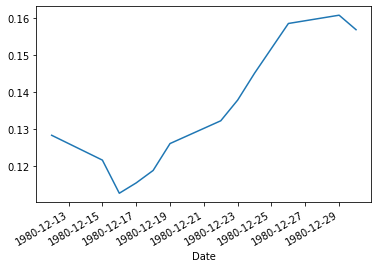

In [7]:
df.loc['1980-12-12':'1980-12-30','Close'].plot() # test date index

In [9]:
df.describe() # Basic statistic of our dataset

,Open,High,Low,Close,Adj Close,Volume
count,10507.000000,10507.000000,10507.000000,10507.000000,10507.000000,1.050700e+04
mean,15.263991,15.435287,15.096734,15.273098,14.622191,3.298789e+08
std,32.922913,33.316968,32.550122,32.952387,32.635637,3.385868e+08
min,0.049665,0.049665,0.049107,0.049107,0.038276,0.000000e+00
25%,0.284598,0.290179,0.276786,0.284598,0.236030,1.230320e+08
50%,0.477679,0.486607,0.469821,0.477679,0.394581,2.174648e+08
75%,15.230000,15.348928,15.086607,15.240893,13.201062,4.094202e+08
max,182.630005,182.940002,179.119995,182.009995,181.259918,7.421641e+09


In [11]:
# see if our dataset have some missing values.
df.isna().sum()
# We zero missing value for all columns of our dataset

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

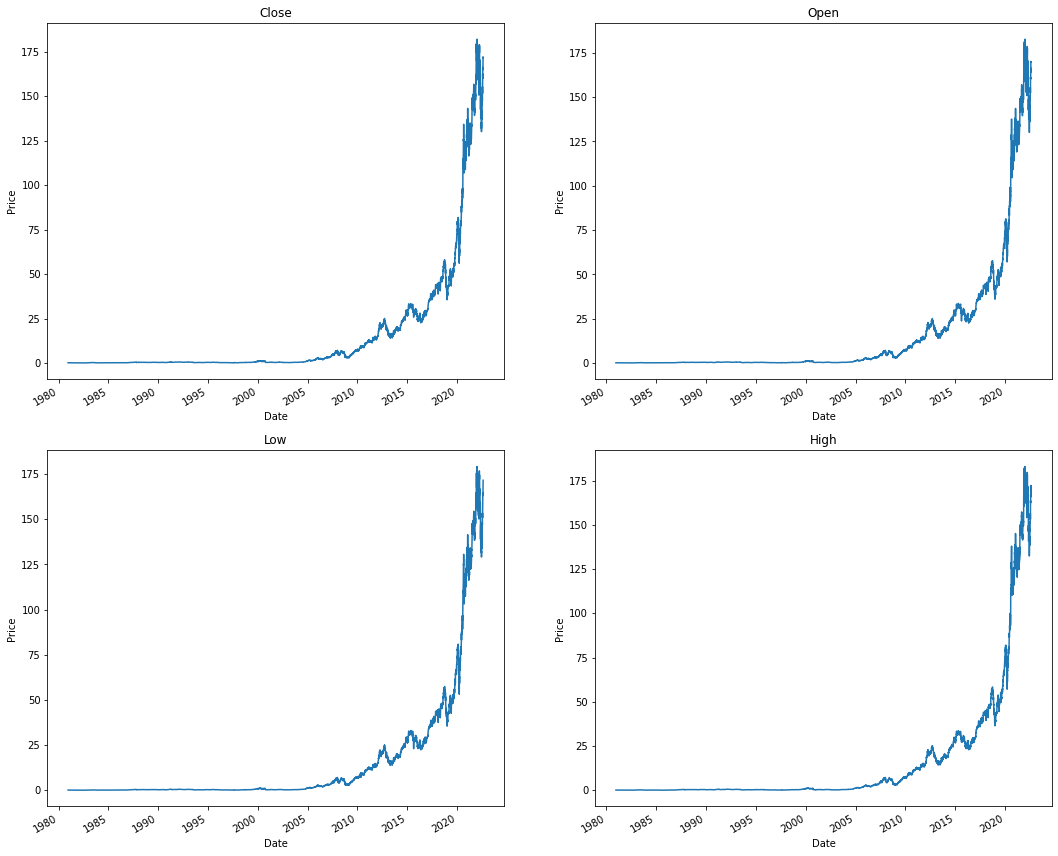

In [28]:
# Ploting the Close, Open , Low, High columns
columns = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(18, 16))
for i in range(len(columns)):
    plt.subplot(2, 2, i+1)
    plt.title(columns[i])
    df[columns[i]].plot()
    plt.ylabel('Price')
    plt.xlabel('Date')
plt.show()

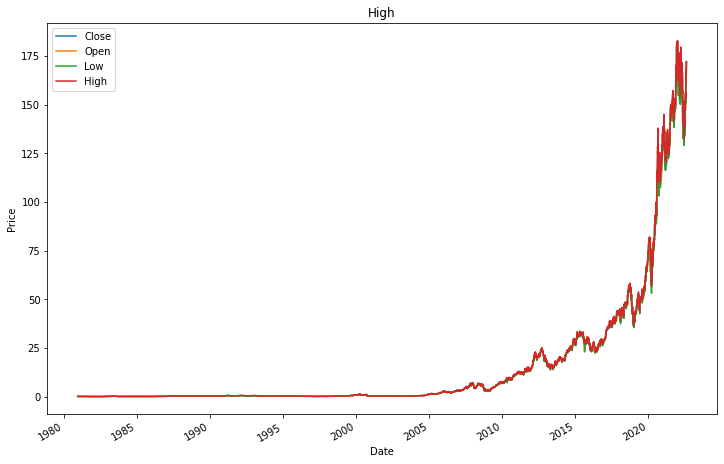

In [35]:
# plot sur la même figure
plt.figure(figsize=(12, 8))
for i in range(len(columns)):
    plt.title(columns[i])
    df[columns[i]].plot()
    plt.ylabel('Price')
    plt.xlabel('Date')
plt.legend()
plt.show()

Si on regarde très bien la graphique ci-desuis, on vois clairement que nos variables sont hyper bien corrélés.
Donc c'est mieux d'utiliser une seule variable que plusieur variable bien corrélés. Dans notre cas, nous allons utiliser la variable Close pour entrainer notre model.

### Data preprocessing

In [44]:
# Create a new dataset with only Close column.
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Close'])
for i in range(0,len(data)):
    new_dataset["Close"][i]=data["Close"][i]
new_dataset.index = data.index

In [48]:
new_dataset.shape

(10507, 1)

In [45]:
new_dataset.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


In [49]:
# Data normalisation with sklearn minMaxscaler

scaler=MinMaxScaler(feature_range=(0,1)) # Initiase scaler
final_dataset=new_dataset.values
train_data=final_dataset[0:8000,:] # split train and test data
test_data=final_dataset[8000:,:]
scaled_data=scaler.fit_transform(final_dataset)

In [50]:
scaled_data.shape

(10507, 1)

In [52]:
type(scaled_data)

numpy.ndarray

In [55]:
# Create x_train and y_train to train model.

x_train, y_train =[],[]
for i in range(60,len(train_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [57]:
print('x_train shape ', x_train.shape)
print('y_train shape ', y_train.shape)

x_train shape  (7940, 60, 1)
y_train shape  (7940,)


## Modeling

### Model training

We will use LSTM (Long short term Memory) to train our model.

In [1]:
# importing
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


2022-08-15 22:30:59.497677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 22:30:59.497729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [74]:
#modeling
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [75]:
model.summary() # summary of model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)               

In [73]:
model.fit(x_train, y_train, epochs=100, batch_size=3, verbose=1) #training model

7940/7940 [==============================] - 443s 55ms/step - loss: 1.5616e-05 - accuracy: 1.2594e-04


### Model valildation 

In [ ]:
# Prepare new input for model testing
inputs = new_dataset[len(new_dataset) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

x_test=[]
for i in range(60,inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
test_data = new_dataset[8000:]
train_data = new_dataset[:8000]
test_data['Predictions'] = closing_price